In [1]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

metadata = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        metadata.append(line)

metadata  = np.array(metadata)

angles    = []# for histogram
for line in metadata:
    alpha  = float(line[3])
    angles.append(alpha)

bin_no = 100
plt.figure(0)
hobj = plt.hist(angles, bins=bin_no)
bin_cnt = hobj[0] # bin size
bin_bnd = hobj[1] # bin boundaries/ edges
limit  = 200
def unbias_dataset(metadata, limit=limit):
    '''function reduces bias by reducing number of samples for frequent steering angles to a limit'''
    sample_no = len(metadata)
    unbiased_md = np.empty([0, metadata.shape[1]], dtype = metadata.dtype)
    for i in range(bin_no):
        subset = np.array([metadata[j] for j in range(sample_no) if angles[j] >= bin_bnd[i] and angles[j] < bin_bnd[i+1]])
        if bin_cnt[i] <= limit:
            unbiased_md = np.append(unbiased_md, subset, axis=0)
        else:
            rand_idx = np.random.choice([idx for idx in range(len(subset))], limit, replace=False)
            unbiased_md = np.append(unbiased_md, subset[rand_idx,:], axis=0)
    unbiased_md = shuffle(unbiased_md)
    return unbiased_md

unbiased_md = unbias_dataset(metadata)
plt.figure(1)
hobj = plt.hist(np.float32(unbiased_md[:,3]), bins=bin_no)
bin_cnt = hobj[0] # bin size
bin_bnd = hobj[1] # bin boundaries/ edges

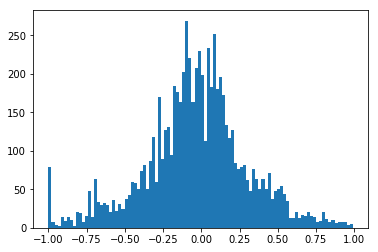

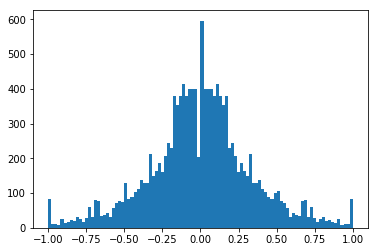

In [2]:
# only angles with samples < limit / 2 will be flipped 
# as we are using generators, histogram below is purely for illustration purposes.
unbiased_ang   = np.float32(unbiased_md[:,3])
plt.figure(0)
hobj = plt.hist(unbiased_ang, bins=bin_no)

from math import floor
augmented_ang = []
for alpha in unbiased_ang:
    augmented_ang.append(alpha)
    augmented_ang.append(alpha*-1)

plt.figure(1)
hobj_aug = plt.hist(augmented_ang, bins=bin_no)


In [3]:
nsamples  = len(unbiased_md)
# selecting random validation data (0.2)
valid_idx = np.random.choice([idx for idx in range(nsamples)],int(0.2*nsamples), replace=False)
valid_md  = unbiased_md[valid_idx]
# selecting rest as training data (0.8)
train_idx = [idx for idx in range(nsamples) if idx not in valid_idx]
train_md  = unbiased_md[train_idx]

def steering_correction(steering_center):
    '''function applies steering correction for left and right cameras'''
    correction_factor = 0.15
    steering_center = steering_center
    steering_left = steering_center + correction_factor
    steering_right = steering_center - correction_factor
    if steering_center > 0:
        steering_left = max(steering_left, steering_center * 2)
        steering_right = min(steering_right, steering_center / 2)
    elif steering_center < 0:
        steering_left = max(steering_left, steering_center / 2)
        steering_right = min(steering_right, steering_center * 2)
   
    return steering_left, steering_right

def train_generator(train_md, batch_size=128):
    num_samples = len(train_md)   
    while True:
        train_md = shuffle(train_md)
        for offset in range(0, num_samples, batch_size):
            train_batch = train_md[offset:offset+batch_size]
            images       = []
            measurements = []
            for line in train_batch:
                steering_center = float(line[3])
                steering_left, steering_right   = steering_correction(steering_center)
                
                # read all center, left and right exactly in that order
                for i in range(3):
                    source_path = line[i]
                    filename = source_path.split('\\')[-1]
                    current_path = 'data/IMG/' + filename
                    image = cv2.imread(current_path)
                    images.append(image)
                    # flip the image for augmentation
                    images.append(cv2.flip(image,1))
                # add steering values. Note: every second image is flipped!
                measurements.extend([steering_center, steering_center*-1.0, steering_left, steering_left*-1.0, steering_right, steering_right*-1.0])
            X_train = np.array(images)
            y_train = np.array(measurements)            
            yield shuffle(X_train, y_train)

def valid_generator(valid_md, batch_size=128):
    num_samples = len(valid_md)   
    while True:
        valid_md = shuffle(valid_md)
        for offset in range(0, num_samples, batch_size):
            valid_batch = valid_md[offset:offset+batch_size]
            images       = []
            measurements = []
            for line in valid_batch:
                steering_center = float(line[3])
                steering_left, steering_right   = steering_correction(steering_center)

                # read all center, left and right exactly in that order
                for i in range(3):
                    source_path = line[i]
                    filename = source_path.split('\\')[-1]
                    current_path = 'data/IMG/' + filename
                    image = cv2.imread(current_path)
                    images.append(image)
                    # flip the image for augmentation
                    images.append(cv2.flip(image,1))
                # add steering values. Note: every second image is flipped!
                measurements.extend([steering_center, steering_center*-1.0, steering_left, steering_left*-1.0, steering_right, steering_right*-1.0])
            X_valid = np.array(images)
            y_valid = np.array(measurements)            
            yield shuffle(X_valid, y_valid)

(array([   82.,    11.,    11.,     7.,    25.,    14.,    18.,    23.,
           21.,    31.,    26.,    16.,    29.,    60.,    31.,    81.,
           77.,    33.,    37.,    43.,    32.,    56.,    71.,    77.,
           74.,   223.,   102.,   128.,   143.,   165.,   179.,   219.,
          241.,   323.,   229.,   251.,   334.,   457.,   437.,   553.,
          628.,   942.,   989.,  1479.,  1653.,  1972.,  2046.,  1844.,
         2135.,  2014.,  2406.,  2135.,  1844.,  2046.,  1972.,  1653.,
         1479.,   989.,   942.,   628.,   553.,   437.,   457.,   334.,
          251.,   229.,   323.,   241.,   219.,   179.,   165.,   143.,
          128.,   102.,   118.,   179.,    77.,    71.,    56.,    32.,
           43.,    37.,    33.,    77.,    81.,    31.,    60.,    29.,
           16.,    26.,    31.,    21.,    23.,    18.,    14.,    25.,
            7.,    11.,    11.,    82.]),
 array([-2.  , -1.96, -1.92, -1.88, -1.84, -1.8 , -1.76, -1.72, -1.68,
        -1.64, -1.6 , -

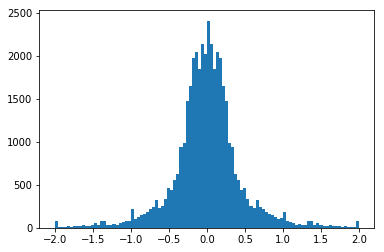

In [4]:
# below we demonstrate steering angle distribution after steering correction for left and right cameras
from math import floor

extended_ang = []
for alpha in augmented_ang:
    extended_ang.append(alpha)
    steering_left, steering_right = steering_correction(alpha)
    extended_ang.append(steering_left)
    extended_ang.append(steering_right)
    
plt.figure(0)
plt.hist(extended_ang, bins=bin_no)


Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/10
5376/5565 [===========================>..] - ETA: 0s - loss: 0.5528

C:\Users\mkule\Anaconda3\envs\carnd-term1-gpu\lib\site-packages\keras\engine\training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


5760/5565 [===============================] - 19s - loss: 0.5467 - val_loss: 0.4380
Epoch 2/10
5760/5565 [===============================] - 14s - loss: 0.3940 - val_loss: 0.3624
Epoch 3/10
5760/5565 [===============================] - 13s - loss: 0.3166 - val_loss: 0.2928
Epoch 4/10
5760/5565 [===============================] - 13s - loss: 0.2960 - val_loss: 0.2603
Epoch 5/10
5760/5565 [===============================] - 13s - loss: 0.2611 - val_loss: 0.2274
Epoch 6/10
5742/5565 [==============================] - 15s - loss: 0.2326 - val_loss: 0.2449
Epoch 7/10
5760/5565 [===============================] - 13s - loss: 0.2271 - val_loss: 0.1908
Epoch 8/10
5760/5565 [===============================] - 14s - loss: 0.2032 - val_loss: 0.2106
Epoch 9/10
5760/5565 [===============================] - 13s - loss: 0.1945 - val_loss: 0.2157
Epoch 10/10
5760/5565 [===============================] - 13s - loss: 0.2025 - val_loss: 0.1751
dict_keys(['val_loss', 'loss'])


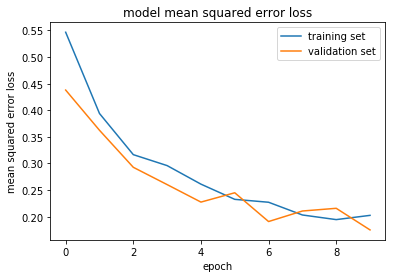

In [5]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Convolution2D, Dropout
from keras.layers import Cropping2D
from keras.regularizers import l2, activity_l2

model = Sequential()
model.add(Cropping2D(cropping=((65,25), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: x / 255.0 - 0.5))
model.add(Convolution2D(24,5,5,subsample=(2,2),activation='relu',W_regularizer=l2(0.001)))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation='relu',W_regularizer=l2(0.001)))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation='relu',W_regularizer=l2(0.001)))
model.add(Convolution2D(64,3,3,activation='relu',W_regularizer=l2(0.001)))
model.add(Convolution2D(64,3,3,activation='relu',W_regularizer=l2(0.001)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(100,W_regularizer=l2(0.001)))
model.add(Dense(50,W_regularizer=l2(0.001)))
model.add(Dense(10,W_regularizer=l2(0.001)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

BATCH_SIZE  = 64
num_train   = len(train_md) 
num_valid   = len(valid_md)
train_gen   = train_generator(train_md, BATCH_SIZE)
valid_gen   = train_generator(valid_md, BATCH_SIZE)
history_object = model.fit_generator(train_gen, validation_data=valid_gen, samples_per_epoch=num_train, nb_val_samples=num_valid, nb_worker=1, nb_epoch=10, verbose=1)
model.save('model.h5')

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training anad validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()